## Let's look at the 38 classes of finnish traffic signs (Orignal SVG files)

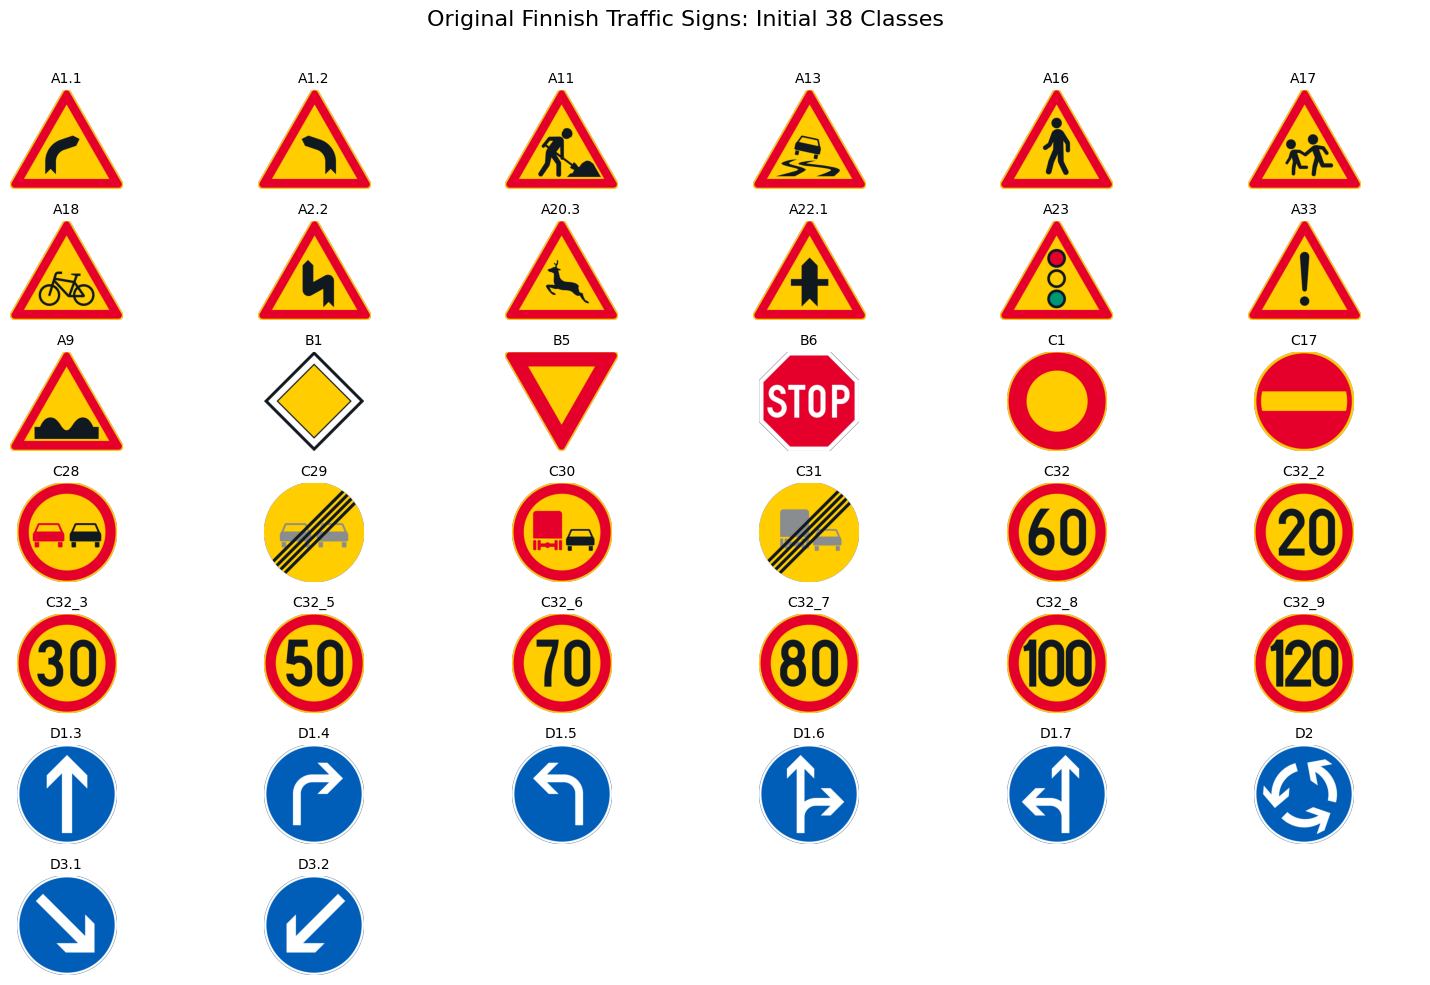

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.image import imread
from cairosvg import svg2png
from io import BytesIO

# Path to the folder containing SVG files
svg_folder = r'C:\Users\ali\workspace\jamk_thesis\thesis_work\orignal_svgs_38_classes\svgs'

# List of traffic sign classes
traffic_sign_classes = [
    'A1.1', 'A1.2', 'A11', 'A13', 'A16', 'A17', 'A18', 'A2.2', 'A20.3', 
    'A22.1', 'A23', 'A33', 'A9', 'B1', 'B5', 'B6', 'C1', 'C17', 'C28', 
    'C29', 'C30', 'C31', 'C32', 'C32_2', 'C32_3', 'C32_5', 'C32_6', 
    'C32_7', 'C32_8', 'C32_9', 'D1.3', 'D1.4', 'D1.5', 'D1.6', 'D1.7', 
    'D2', 'D3.1', 'D3.2'
]

# Prepare the figure for a collage
n_cols = 6  # Number of columns in the collage
n_rows = -(-len(traffic_sign_classes) // n_cols)  # Calculate rows dynamically
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

# Iterate through traffic sign classes and corresponding axes
for idx, (cls, ax) in enumerate(zip(traffic_sign_classes, axes)):
    # Path to the SVG file
    svg_path = os.path.join(svg_folder, f"{cls}.svg")
    
    if os.path.exists(svg_path):
        # Convert SVG to PNG for rendering
        png_data = BytesIO()
        svg2png(url=svg_path, write_to=png_data)
        img = imread(BytesIO(png_data.getvalue()))
        
        # Display the image
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(cls, fontsize=10, pad=5)
    else:
        # If the SVG file doesn't exist, leave the space empty
        ax.axis('off')
        ax.set_title(f"{cls} (Missing)", fontsize=10, pad=5, color='red')

# Turn off any remaining empty axes
for ax in axes[len(traffic_sign_classes):]:
    ax.axis('off')

# Add a title to the collage
plt.suptitle('Original Finnish Traffic Signs: Initial 38 Classes', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## Pre-Process Dataset for Model Training & Testing

In [2]:
import os
import json
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
import re

def sanitize_filename(filename):
    # Replace any character that is not alphanumeric, underscore, hyphen, or dot
    return re.sub(r'[^\w\.-]', '_', filename)

# Set the base directory and train/test directories
base_dir = r'D:\dataset\pure_python_genrated_dataset'  # 120GB 
output_dir = r'D:\dataset\my_structured_dataset_38_classes'
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')

# Create train and test directories outside the "pure_python_genrated_dataset" folder
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Lists to hold image file paths and labels for the CSV files
train_data = []
test_data = []
class_label_Id_mapping_dict = {}
train_classes = []
test_classes = []

# Counter for unique filenames
unique_counter = 0
class_counter = -1

# Traverse through all subdirectories and files in the base directory
for root, dirs, files in os.walk(base_dir):
    # Filter for image files (e.g., .jpg, .jpeg, .png, .svg)
    images = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.svg'))]
    
    # If there are images in the directory, process them
    if images:
        # Split images into train and test sets
        train_images, test_images = train_test_split(images, test_size=0.3, random_state=42)
        
        # Get the class label from the class directory
        # The class label is the parent directory of the current directory
        class_label = os.path.basename(os.path.dirname(root))
        class_label_sanitized = sanitize_filename(class_label)
        
        # Get the subdirectory name
        sub_dir = os.path.basename(root)
        sub_dir_sanitized = sanitize_filename(sub_dir)
        
        # Process and copy the train images
        for img_name in train_images:
            src_path = os.path.join(root, img_name)
            img_name_sanitized = sanitize_filename(img_name)
            
            if class_label not in train_classes:
                class_counter+=1
                train_classes.append(class_label)
                class_label_Id_mapping_dict[class_counter] = class_label
                dst_dirs = os.path.join(train_dir, f"{class_counter}")
                os.makedirs(dst_dirs, exist_ok=True)

            # Create a unique filename
            unique_filename = f"{train_classes.index(class_label)}/{class_label_sanitized}_{sub_dir_sanitized}_{img_name_sanitized}"

            # Check for filename collision
            dst_path = os.path.join(train_dir, f"{unique_filename}")
            if os.path.exists(dst_path):
                unique_counter += 1
                name, ext = os.path.splitext(unique_filename)
                unique_filename = f"{train_classes.index(class_label)}/{name}_{unique_counter}{ext}"
                dst_path = os.path.join(train_dir, unique_filename)
            
            # Copy the image and record the data
            shutil.move(src_path, dst_path)
            train_data.append({'filename': unique_filename, 'class': class_label, 'classId': train_classes.index(class_label)})
        
        # Process and copy the test images
        for img_name in test_images:
            src_path = os.path.join(root, img_name)
            img_name_sanitized = sanitize_filename(img_name)

            if class_label not in test_classes:
                test_classes.append(class_label)
            
            # Create a unique filename
            unique_filename = f"{class_label_sanitized}_{sub_dir_sanitized}_{img_name_sanitized}"
            
            # Check for filename collision
            dst_path = os.path.join(test_dir, unique_filename)
            if os.path.exists(dst_path):
                unique_counter += 1
                name, ext = os.path.splitext(unique_filename)
                unique_filename = f"{name}_{unique_counter}{ext}"
                dst_path = os.path.join(test_dir, unique_filename)
            
            # Copy the image and record the data
            shutil.move(src_path, dst_path)
            test_data.append({'filename': unique_filename, 'class': class_label, 'classId': test_classes.index(class_label)})

# Create DataFrames for train and test data
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

# Save the DataFrames to CSV files outside the "pure_python_genrated_dataset" folder
train_csv_path = os.path.join(output_dir, 'Train.csv')
test_csv_path = os.path.join(output_dir, 'Test.csv')
train_df.to_csv(train_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

print(f"Train and test split completed. CSV files created at {train_csv_path} and {test_csv_path}.")

print(json.dumps(class_label_Id_mapping_dict))

Train and test split completed. CSV files created at D:\dataset\my_structured_dataset_38_classes\Train.csv and D:\dataset\my_structured_dataset_38_classes\Test.csv.
{"0": "A1.1", "1": "A1.2", "2": "A11", "3": "A13", "4": "A16", "5": "A17", "6": "A18", "7": "A2.2", "8": "A20.3", "9": "A22.1", "10": "A23", "11": "A33", "12": "A9", "13": "B1", "14": "B5", "15": "B6", "16": "C1", "17": "C17", "18": "C28", "19": "C29", "20": "C30", "21": "C31", "22": "C32", "23": "C32_2", "24": "C32_3", "25": "C32_5", "26": "C32_6", "27": "C32_7", "28": "C32_8", "29": "C32_9", "30": "D1.3", "31": "D1.4", "32": "D1.5", "33": "D1.6", "34": "D1.7", "35": "D2", "36": "D3.1", "37": "D3.2"}


## Let's Look at dataset for model training.

#### Dataset Created with the help of Blender and Python OpenCV module.

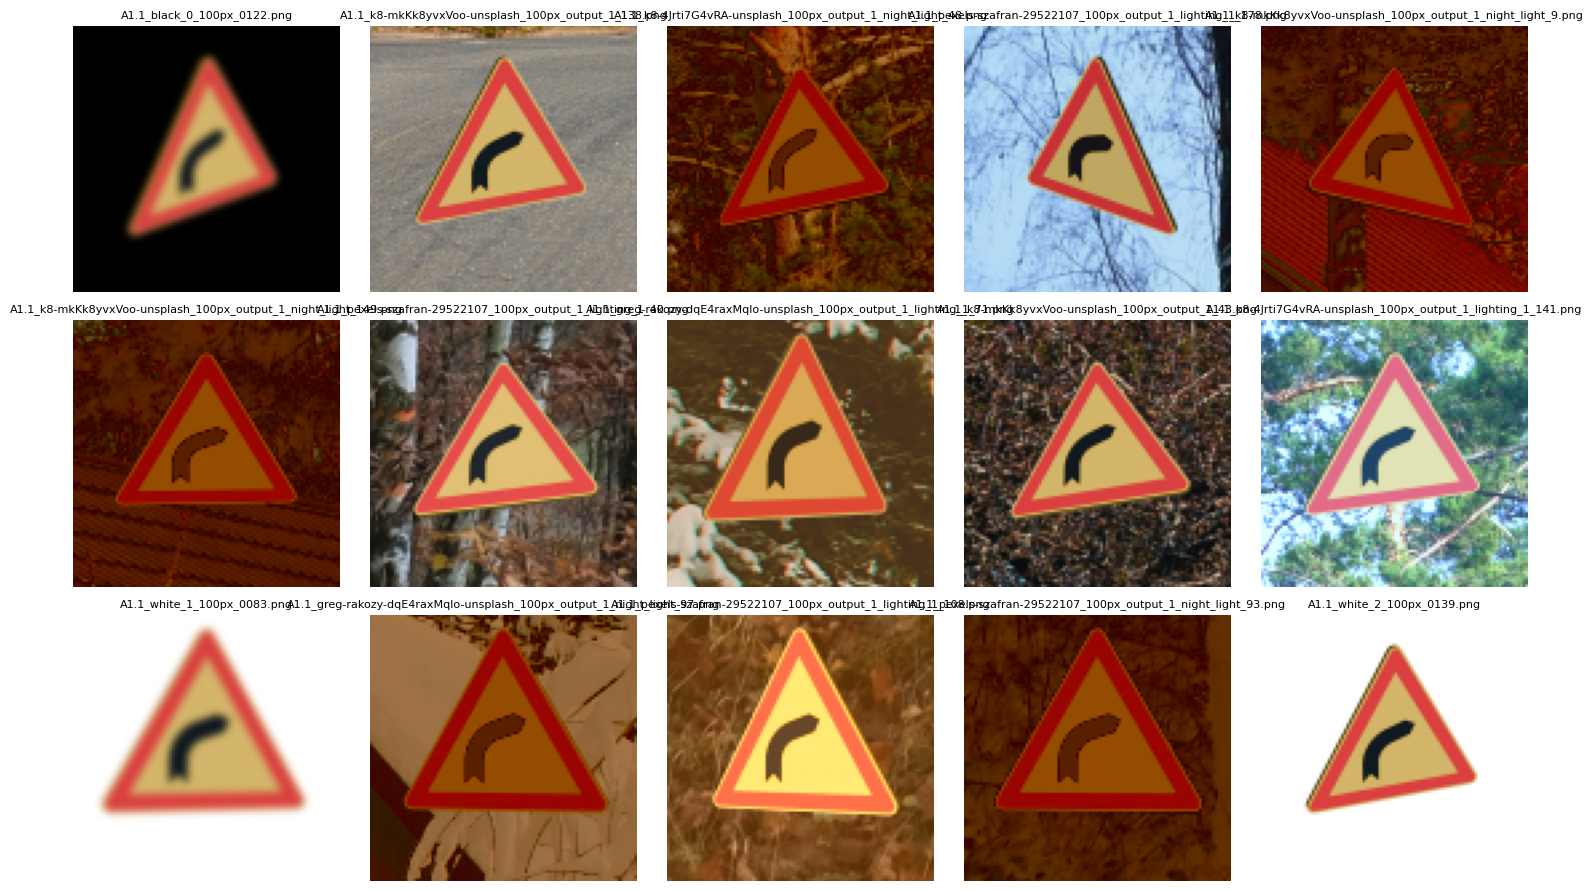

In [3]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

def display_collage(base_dir, num_cols=4, num_images=15, skip=0):
    """
    Display a collage of images from a directory, skipping a dynamic number of images.

    :param base_dir: Path to the directory containing images
    :param num_cols: Number of columns in the collage
    :param num_images: Number of images to display in the collage
    :param skip: Number of images to skip at the start of the directory
    """
    # Get the list of image files in the base directory
    images = [f for f in os.listdir(base_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Skip the specified number of images
    images = images[skip:]

    # Randomly select the desired number of images
    selected_images = random.sample(images, min(num_images, len(images)))

    # Calculate rows needed for the collage
    num_rows = (len(selected_images) + num_cols - 1) // num_cols

    # Create the collage
    plt.figure(figsize=(num_cols * 3, num_rows * 3))  # Adjust size dynamically

    for i, image_name in enumerate(selected_images):
        image_path = os.path.join(base_dir, image_name)
        img = Image.open(image_path)

        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.axis('off')  # Turn off axis
        plt.title(image_name, fontsize=8)

    plt.tight_layout()
    plt.show()

# Example usage
base_dir = r'D:\dataset\my_structured_dataset_38_classes\train\0' 
num_cols = 5  # Number of columns
num_images = 15  # Number of images to display
skip = 10  # Number of images to skip

display_collage(base_dir, num_cols=num_cols, num_images=num_images, skip=skip)


##	EfficientNetB0: Model Training 38 Classes

In [84]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2

from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, Input

In [85]:
# Setting variables for later use
data_ = []
labels_ = []
classes = 38

# Retrieving the images and their labels
for i in range(classes):
    path = os.path.join(r"D:\dataset\my_structured_dataset_38_classes\\", "Train", str(i))

    # Check if the folder exists
    if not os.path.exists(path):
        print(f"Folder {path} does not exist. Skipping class {i}.")
        continue  # Skip this iteration if folder does not exist

    images = os.listdir(path)

    for a in images:
        try:
            image = Image.open(os.path.join(path, a))
            # Convert to RGB if not already in that format
            image = image.convert("RGB")
            image = image.resize((100, 100))
            image = np.array(image)
            
            # Check if the image has the correct shape
            if image.shape == (100, 100, 3):
                data_.append(image)
                labels_.append(i)
            else:
                print(f"Image {a} has an unexpected shape {image.shape}. Skipping.")
        except Exception as e:
            print(f"Error loading image {a}: {e}")

In [90]:
# Converting lists into numpy arrays
data = np.array(data_)
labels = np.array(labels_)

print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")

Data shape: (86488, 100, 100, 3), Labels shape: (86488,)


In [91]:
# Checking data shape
print(data.shape, labels.shape)

# Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Displaying the shape after the split
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Converting the labels into one hot encoding
y_train = to_categorical(y_train, classes)
y_test = to_categorical(y_test, classes)

(86488, 100, 100, 3) (86488,)
(69190, 100, 100, 3) (17298, 100, 100, 3) (69190,) (17298,)


In [92]:
# Set input size to 100x100
input_tensor = Input(shape=(100, 100, 3))

# Load the EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Fine-tune: Unfreeze some top layers
base_model.trainable = True  # Enable fine-tuning for the whole model
for layer in base_model.layers[:-20]:  # Freeze most layers, unfreeze top 20
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)  # Adjust dropout rate
output = Dense(classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile with a lower learning rate
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "functional_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)    │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_8 (Rescaling)       │ (None, 100, 100, 3)       │               0 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_4               │ (None, 100, 100, 3)       │               7 │ rescaling_8[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_9 (Rescaling)       │ (None, 100, 100, 3)       │               0 │ normalization_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 101, 101, 3)       │               0 │ rescaling_9[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 50, 50, 32)        │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 50, 50, 32)        │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 50, 50, 32)        │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 50, 50, 32)        │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 50, 50, 32)        │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 50, 50, 32)        │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             28

 Total params: 4,387,273 (16.74 MB)

 Trainable params: 1,688,662 (6.44 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

In [93]:
# Training the Model
with tf.device('/GPU:0'):
    epochs = 15
    history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/15
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 613s 264ms/step - accuracy: 0.5796 - loss: 1.4158 - val_accuracy: 0.9608 - val_loss: 0.1041
Epoch 2/15
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 563s 260ms/step - accuracy: 0.9404 - loss: 0.1630 - val_accuracy: 0.9920 - val_loss: 0.0254
Epoch 3/15
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 567s 262ms/step - accuracy: 0.9797 - loss: 0.0648 - val_accuracy: 0.9940 - val_loss: 0.0166
Epoch 4/15
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 562s 260ms/step - accuracy: 0.9859 - loss: 0.0420 - val_accuracy: 0.9969 - val_loss: 0.0099
Epoch 5/15
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 562s 260ms/step - accuracy: 0.9909 - loss: 0.0278 - val_accuracy: 0.9980 - val_loss: 0.0053
Epoch 6/15
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 562s 260ms/step - accuracy: 0.9919 - loss: 0.0244 - val_accuracy: 0.9981 - val_loss: 0.0052
Epoch 7/15
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 561s 259ms/step - accuracy: 0.9942 - loss: 0.0181 - val_accuracy: 0.9984 - val_loss: 0.0050
Epoch 8/15
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 563s 261ms/step - ac

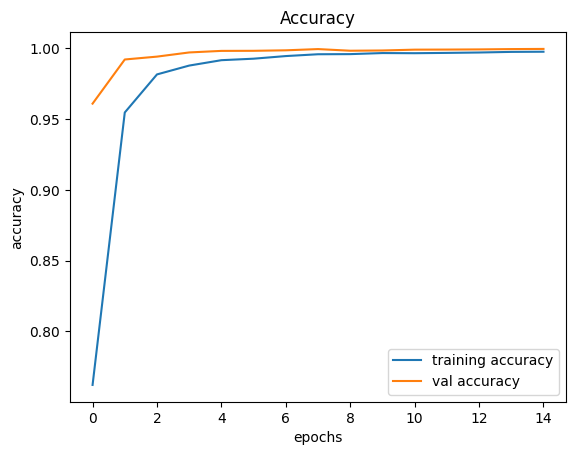

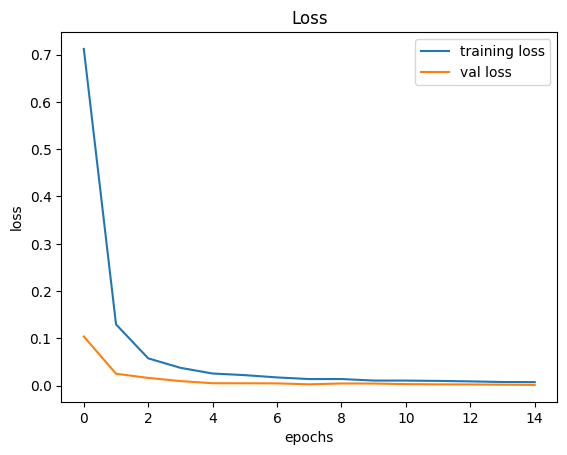

In [94]:
# Plotting performance graphs
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [95]:
# testing accuracy on test dataset
from sklearn.metrics import accuracy_score

# Importing the test dataset
y_test = pd.read_csv(r"D:\dataset\my_structured_dataset_38_classes\\Test.csv")

labels = y_test["classId"].values
imgs = y_test["filename"].values

data=[]

# Retreiving the images
with tf.device('/GPU:0'):
    for img in imgs:
        image = Image.open(r"D:\dataset\my_structured_dataset_38_classes\\Test\\"+img)
        image = image.convert("RGB")
        image = image.resize([100, 100])
        data.append(np.array(image))

X_test=np.array(data)

with tf.device('/GPU:0'):
    pred = np.argmax(model.predict(X_test), axis=-1)

print(accuracy_score(labels, pred))

1167/1167 ━━━━━━━━━━━━━━━━━━━━ 205s 173ms/step
0.9990084682173866


In [96]:
# Saving the Model
# Save the model in the native Keras format
model.save(r"D:\dataset\my_structured_dataset_38_classes\\finnish_traffic_sign_classifier_38_classes_new_dataset.keras")

In [7]:
class_labels = {
  "0": "A1.1",
  "1": "A1.2",
  "2": "A11",
  "3": "A13",
  "4": "A16",
  "5": "A17",
  "6": "A18",
  "7": "A2.2",
  "8": "A20.3",
  "9": "A22.1",
  "10": "A23",
  "11": "A33",
  "12": "A9",
  "13": "B1",
  "14": "B5",
  "15": "B6",
  "16": "C1",
  "17": "C17",
  "18": "C28",
  "19": "C29",
  "20": "C30",
  "21": "C31",
  "22": "C32",
  "23": "C32_2",
  "24": "C32_3",
  "25": "C32_5",
  "26": "C32_6",
  "27": "C32_7",
  "28": "C32_8",
  "29": "C32_9",
  "30": "D1.3",
  "31": "D1.4",
  "32": "D1.5",
  "33": "D1.6",
  "34": "D1.7",
  "35": "D2",
  "36": "D3.1",
  "37": "D3.2"
}


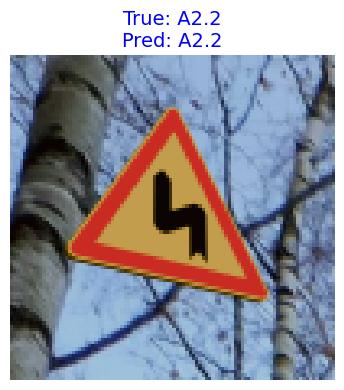

---------------------------------------------



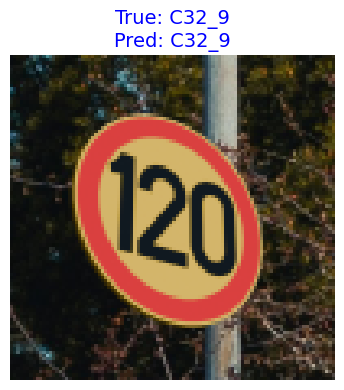

---------------------------------------------



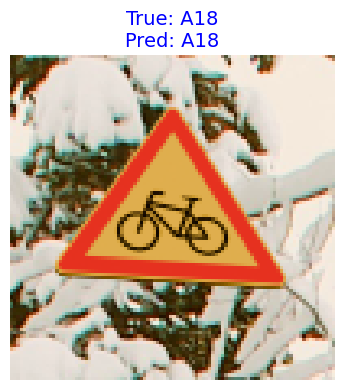

---------------------------------------------



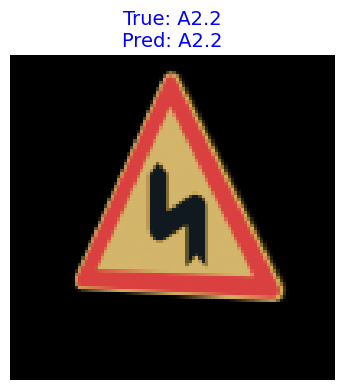

---------------------------------------------



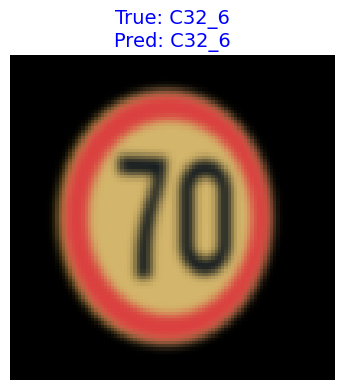

---------------------------------------------



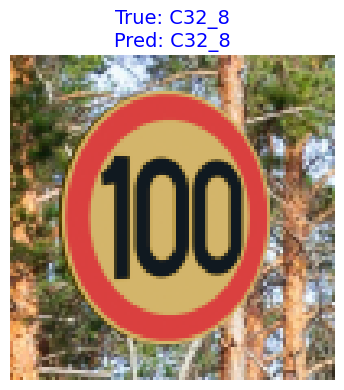

---------------------------------------------



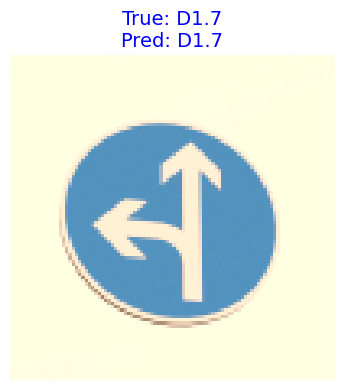

---------------------------------------------



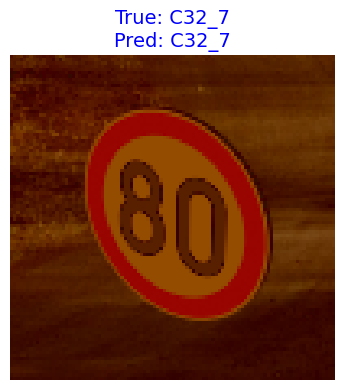

---------------------------------------------



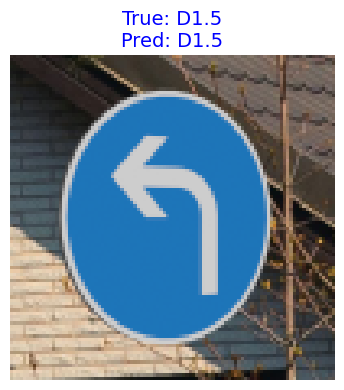

---------------------------------------------



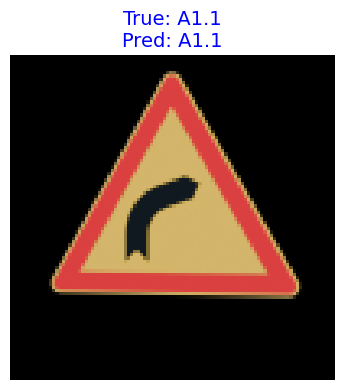

---------------------------------------------



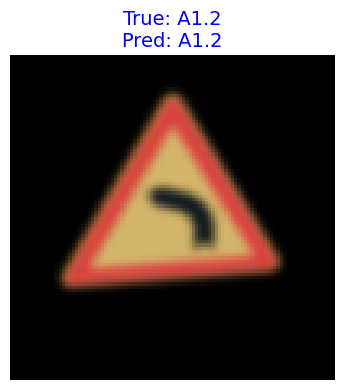

---------------------------------------------



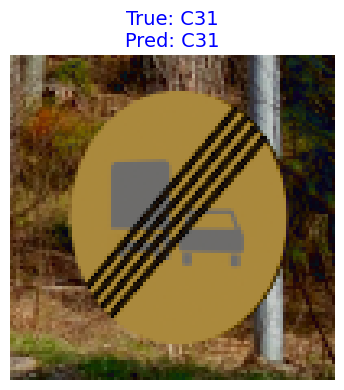

---------------------------------------------



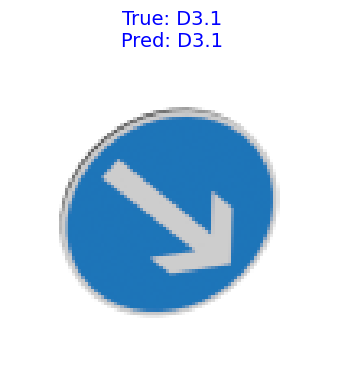

---------------------------------------------



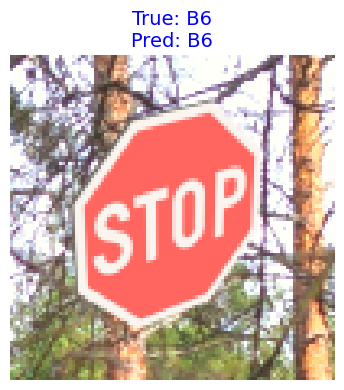

---------------------------------------------



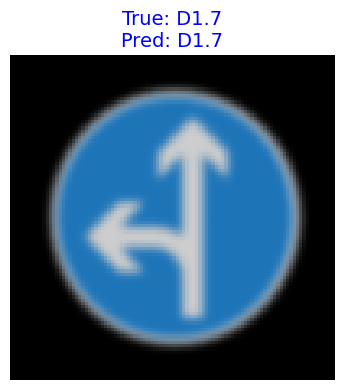

---------------------------------------------



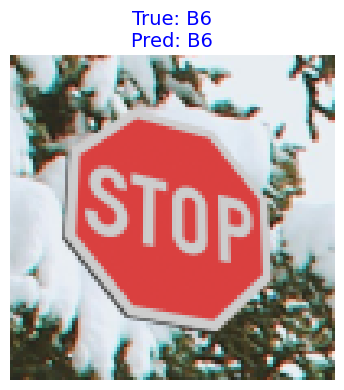

---------------------------------------------



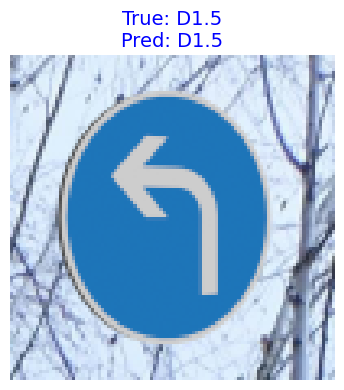

---------------------------------------------



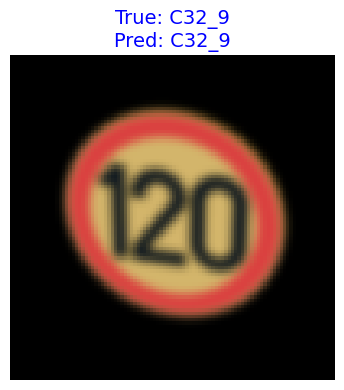

---------------------------------------------



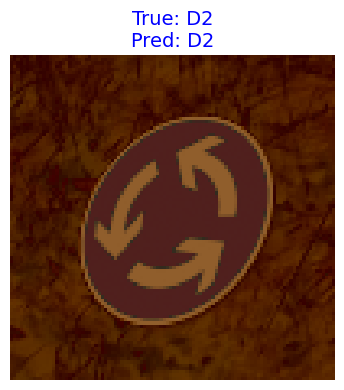

---------------------------------------------



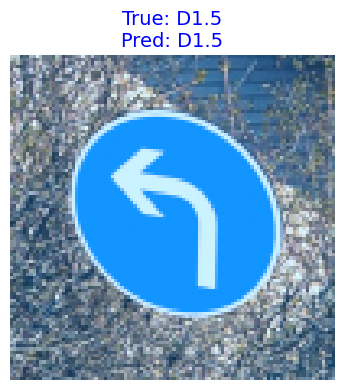

---------------------------------------------



In [98]:
# Number of samples to visualize
num_samples = 20

# Randomly select 20 images from the test set
indices = np.random.choice(len(X_test), num_samples, replace=False)
sample_images = X_test[indices]
true_labels = labels[indices]
predicted_labels = pred[indices]

# Function to display an image with true and predicted labels
def display_image_with_labels(image, true_label, predicted_label):
    plt.figure(figsize=(4, 4))  # Set the figure size for better visibility
    plt.imshow(image.astype('uint8'))  # Display the image
    plt.title(f"True: {class_labels[str(true_label)]}\nPred: {class_labels[str(predicted_label)]}", 
              fontsize=14, color='blue')  # Display class names with a readable font size
    plt.axis('off')  # Remove the axes for a cleaner look
    plt.tight_layout()
    plt.show()

# Display 20 images one by one with true and predicted labels
for i in range(num_samples):
    display_image_with_labels(sample_images[i], true_labels[i], predicted_labels[i])
    print("---------------------------------------------\n")


In [56]:
from sklearn.metrics import classification_report
# Classification report
report = classification_report(labels, pred, target_names=[str(i) for i in range(classes)])

print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       982
           1       1.00      1.00      1.00       982
           2       1.00      1.00      1.00       982
           3       0.99      1.00      1.00       982
           4       1.00      1.00      1.00       982
           5       1.00      1.00      1.00       982
           6       1.00      1.00      1.00       982
           7       1.00      1.00      1.00       982
           8       1.00      1.00      1.00       982
           9       1.00      1.00      1.00       982
          10       1.00      1.00      1.00       982
          11       1.00      1.00      1.00       982
          12       1.00      1.00      1.00       982
          13       1.00      1.00      1.00       982
          14       1.00      1.00      1.00       982
          15       1.00      0.98      0.99       982
          16       1.00      1.00      1.00       982
          17       0.99    

## Now, Let's Test Model Accuracy on real world data

In [12]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

model = tf.keras.models.load_model(r"D:\dataset\my_structured_dataset_38_classes\\finnish_traffic_sign_classifier_38_classes_new_dataset.keras")

# Root directory containing class-labeled subdirectories
root_dir = r'C:\Users\ali\workspace\jamk_thesis\thesis_work\creating_new_dataset\real_world_croped_images_dataset'

# Get the list of class names (subdirectory names)
classes = os.listdir(root_dir)

class_name_to_ids = {class_name: int(idx) for idx, class_name in class_labels.items()}

image_paths = []
labels = []

# Loop over each class directory
for class_name in classes:
    class_dir = os.path.join(root_dir, class_name)
    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                if class_name in class_name_to_ids:
                    image_path = os.path.join(class_dir, filename)
                    image_paths.append(image_path)
                    labels.append(class_name_to_ids[class_name])

data = []
sample_imgs = []

# Use GPU if available
with tf.device('/GPU:0'):
    for img_path in image_paths:
        image = Image.open(img_path)
        image = image.convert("RGB")
        sample_imgs.append(image.resize((100, 100)))
        image = image.resize((100, 100))
        data.append(np.array(image))

X_test = np.array(data)
X_test_disp = np.array(sample_imgs)
y_true = np.array(labels)
print("Sample Images Count: ", len(sample_imgs))

Sample Images Count:  39


In [14]:
with tf.device('/GPU:0'):
    predictions = model.predict(X_test)
    pred = np.argmax(predictions, axis=-1)
    pred_conf = np.max(predictions, axis=-1)
accuracy = accuracy_score(y_true, pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step
Model Accuracy: 94.87%


In [15]:
import numpy as np
import matplotlib.pyplot as plt

def display_collage_with_labels(images, true_labels, predicted_labels, class_labels, confidences, num_cols=4):
    """
    Display a collage of images with true labels, predicted labels, and prediction confidence.

    :param images: Array of images
    :param true_labels: Array of true labels
    :param predicted_labels: Array of predicted labels
    :param class_labels: Dictionary mapping label indices to class names
    :param confidences: Array of prediction confidence scores (same order as predicted labels)
    :param num_cols: Number of columns in the collage
    """
    num_images = len(images)
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate number of rows needed

    plt.figure(figsize=(num_cols * 3, num_rows * 3))  # Set figure size dynamically

    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i].astype('uint8'))  # Display the image
        true_label = class_labels[str(true_labels[i])]
        predicted_label = class_labels[str(predicted_labels[i])]
        confidence = confidences[i]  # Get the confidence for the prediction
        plt.title(f"True: {true_label}\nPred: {predicted_label} ({confidence*100:.1f}%)", fontsize=10, color='blue')
        plt.axis('off')  # Remove axes for cleaner display

    plt.tight_layout()
    plt.show()

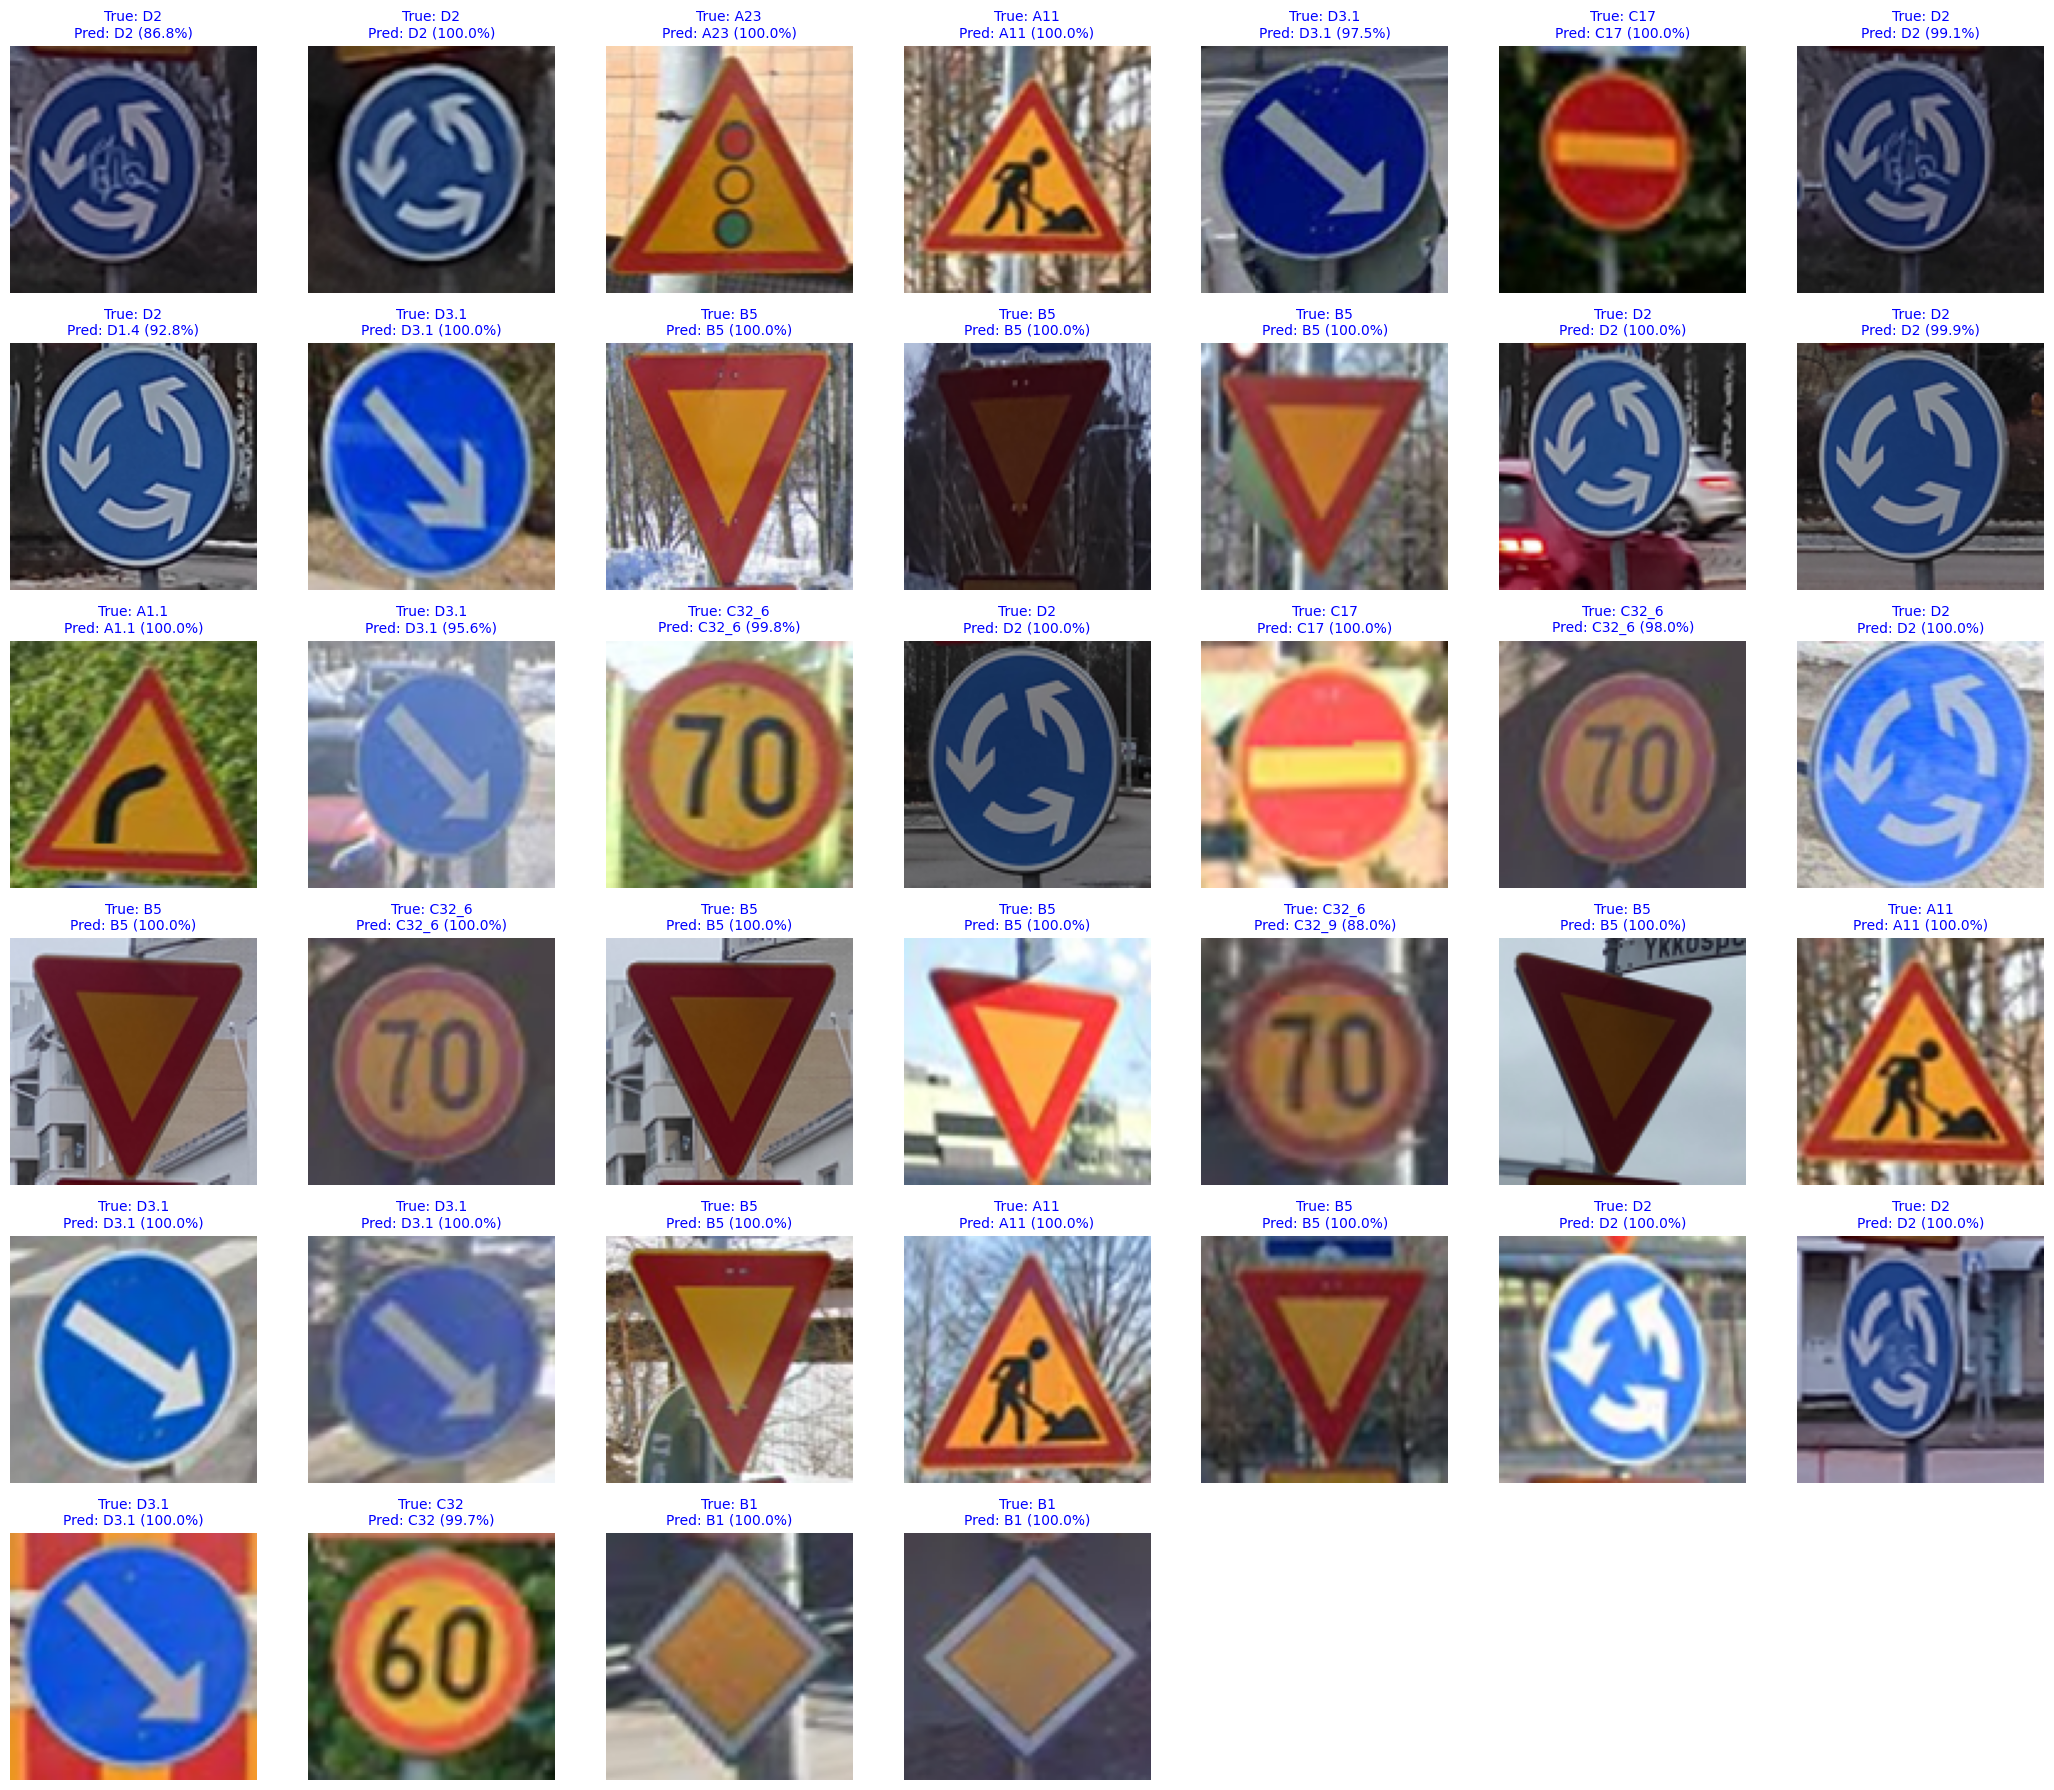

In [16]:
# Number of samples to visualize
num_samples = 39

# Randomly select samples from the test set
indices = np.random.choice(len(X_test), num_samples, replace=False)
sample_images = X_test_disp[indices]
true_labels = y_true[indices]
predicted_labels = pred[indices]
confidences = pred_conf[indices]

num_cols = 7
# Display the collage
display_collage_with_labels(sample_images, true_labels, predicted_labels, class_labels, confidences, num_cols=num_cols)